In [1]:
INPUT = "model_data/example_study"

In [2]:
# Standard library imports
import os
import math
import glob
import json
import pickle

# Third-party library imports
import torch
import torchvision
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import pydicom
import sklearn
import sklearn.metrics

# Hugging Face Hub
from huggingface_hub import PyTorchModelHubMixin

# Local module imports
import utils
import video_utils

In [3]:
device=torch.device("cuda")

In [4]:
vc_checkpoint = torch.load("model_data/weights/view_classifier.ckpt")
vc_state_dict={key[6:]:value for key,value in vc_checkpoint['state_dict'].items()}
view_classifier = torchvision.models.convnext_base()
view_classifier.classifier[-1] = torch.nn.Linear(
    view_classifier.classifier[-1].in_features, 11
)
view_classifier.load_state_dict(vc_state_dict)
view_classifier.to(device)
view_classifier.eval()
for param in view_classifier.parameters():
    param.requires_grad = False

In [5]:
frames_to_take=32
frame_stride=2
video_size=224
mean = torch.tensor([29.110628, 28.076836, 29.096405]).reshape(3, 1, 1, 1)
std = torch.tensor([47.989223, 46.456997, 47.20083]).reshape(3, 1, 1, 1)

def process_dicoms(INPUT):
    """
    Reads DICOM video data from the specified folder and returns a tensor 
    formatted for input into the EchoPrime model.

    Args:
        INPUT (str): Path to the folder containing DICOM files.

    Returns:
        stack_of_videos (torch.Tensor): A float tensor of shape  (N, 3, 16, 224, 224)
                                        representing the video data where N is the number of videos,
                                        ready to be fed into EchoPrime.
    """

    dicom_paths = glob.glob(f'{INPUT}/**/*.dcm',recursive=True)
    stack_of_videos=[]
    for idx, dicom_path in tqdm(enumerate(dicom_paths),total=len(dicom_paths)):
        try:
            # simple dicom_processing
            dcm=pydicom.dcmread(dicom_path)
            pixels = dcm.pixel_array
            
            # exclude images like (600,800) or (600,800,3)
            if pixels.ndim < 3 or pixels.shape[2]==3:
                continue 
                
            # if single channel repeat to 3 channels    
            if pixels.ndim==3:
                
                pixels = np.repeat(pixels[..., None], 3, axis=3)
            
            # mask everything outside ultrasound region
            pixels=video_utils.mask_outside_ultrasound(dcm.pixel_array)
            
            
            
            #model specific preprocessing
            x = np.zeros((len(pixels),224,224,3))
            for i in range(len(x)):
                x[i] = video_utils.crop_and_scale(pixels[i])
            
            x = torch.as_tensor(x, dtype=torch.float).permute([3,0,1,2])
            # normalize
            x.sub_(mean).div_(std)
        
            ## if not enough frames add padding
            if x.shape[1] < frames_to_take:
                padding = torch.zeros(
                (
                    3,
                    frames_to_take - x.shape[1],
                    video_size,
                    video_size,
                ),
                dtype=torch.float,
                )
                x = torch.cat((x, padding), dim=1)
                
            start=0
            stack_of_videos.append(x[:, start : ( start + frames_to_take) : frame_stride, : , : ])
            
        except Exception as e:
            print("corrupt file")
            print(str(e))

    stack_of_videos=torch.stack(stack_of_videos)
    
    return stack_of_videos

In [6]:
def get_view_list(stack_of_videos, visualize=False):
    """
    Args:
        stack_of_videos (torch.Tensor): A float tensor with preprocessed echo video data
        
    Returns:
        view_list A list of predicted views
    """
    ## get views   
    stack_of_first_frames = stack_of_videos[:,:,0,:,:].to(device)
    with torch.no_grad():
        out_logits=view_classifier(stack_of_first_frames)
    out_views=torch.argmax(out_logits,dim=1)
    view_list = [utils.COARSE_VIEWS[v] for v in out_views]

    # visualize images and the assigned views
    if visualize:
        print("Preprocessed and normalized video inputs")
        rows, cols = (len(view_list) // 12 + (len(view_list) % 9 > 0)), 12
        fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
        axes = axes.flatten()
        for i in range(len(view_list)):
            display_image = (stack_of_first_frames[i].cpu().permute([1,2,0]) * 255).numpy()
            display_image = np.clip(display_image, 0, 255).astype('uint8')
            display_image = np.ascontiguousarray(display_image)
            display_image = cv2.cvtColor(display_image, cv2.COLOR_RGB2BGR)
            cv2.putText(display_image, view_list[i].replace("_"," "), (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 220, 255), 2)
            axes[i].imshow(display_image)
            axes[i].axis('off')

        for j in range(i + 1, len(axes)):
            axes[j].axis('off')
        plt.subplots_adjust(wspace=0.05, hspace=0.05)
        plt.show()

        
    return view_list

100%|██████████| 50/50 [00:19<00:00,  2.62it/s]


Preprocessed and normalized video inputs


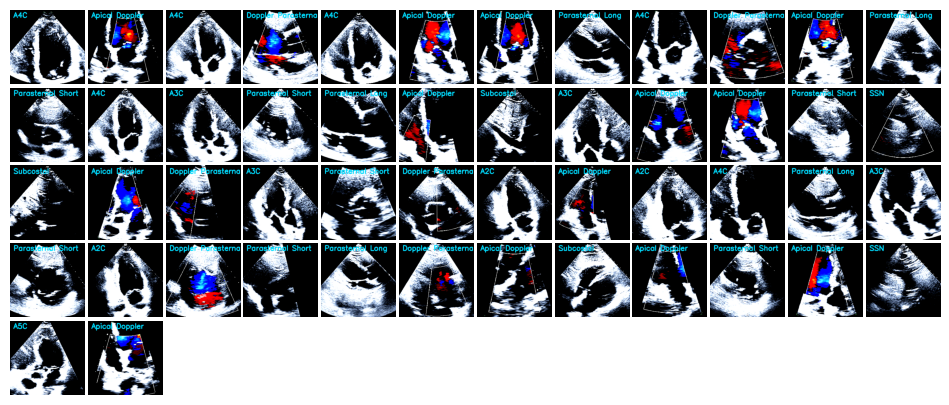

['A4C', 'Apical_Doppler', 'A4C', 'Doppler_Parasternal_Long', 'A4C', 'Apical_Doppler', 'Apical_Doppler', 'Parasternal_Long', 'A4C', 'Doppler_Parasternal_Short', 'Apical_Doppler', 'Parasternal_Long', 'Parasternal_Short', 'A4C', 'A3C', 'Parasternal_Short', 'Parasternal_Long', 'Apical_Doppler', 'Subcostal', 'A3C', 'Apical_Doppler', 'Apical_Doppler', 'Parasternal_Short', 'SSN', 'Subcostal', 'Apical_Doppler', 'Doppler_Parasternal_Short', 'A3C', 'Parasternal_Short', 'Doppler_Parasternal_Short', 'A2C', 'Apical_Doppler', 'A2C', 'A4C', 'Parasternal_Long', 'A3C', 'Parasternal_Short', 'A2C', 'Doppler_Parasternal_Short', 'Parasternal_Short', 'Parasternal_Long', 'Doppler_Parasternal_Long', 'Apical_Doppler', 'Subcostal', 'Apical_Doppler', 'Parasternal_Short', 'Apical_Doppler', 'SSN', 'A5C', 'Apical_Doppler']


In [7]:
stack_of_videos=process_dicoms(INPUT)
view_list=get_view_list(stack_of_videos,visualize=True)
print(view_list)